In [1]:
import torch
import gc
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
from torch import nn
from torch import optim
import json
from PIL import Image
import io
import cv2
import torchvision.transforms.functional as TF
from torchvision.utils import save_image
from torchvision.transforms import ToPILImage
from matplotlib import pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as data
import torch.optim as optim
from torch.optim import lr_scheduler
from tqdm import tqdm
import time
import os
import copy
import pickle
import urllib.request
import requests
from matplotlib.pyplot import imshow
import random

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(0)
from utils import *

In [81]:
#Function to display image and predicted class
def imstats(name):
    # read in image and view it
    x = readim(name, forward_normalize) 
    imshow_tensor(x[0], inv_normalize)

    #get predicted class and probability
    prob = lay2(pretrained_model(x.cuda()))
    maxcls = prob.max(1)
    print("Class is {} ({}) with confidence {}%".format(maxcls.indices.item(),class_dict[maxcls.indices.item()],round(maxcls.values.item()*100,4)))

(3024, 3024)


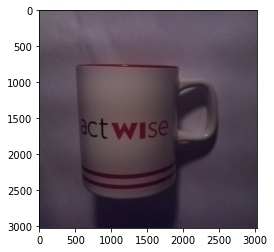

In [633]:
#Get classes
CLASS_URL = 'https://gist.githubusercontent.com/yrevar/6135f1bd8dcf2e0cc683/raw/d133d61a09d7e5a3b36b8c111a8dd5c4b5d560ee/imagenet1000_clsid_to_human.pkl'
class_dict = pickle.load(urllib.request.urlopen(CLASS_URL))

#Retrieve image and assign class
#IMG_URL = "https://bloximages.chicago2.vip.townnews.com/chippewa.com/content/tncms/assets/v3/editorial/c/ca/cca0d87d-8d7c-520f-b012-bc065d18b3dd/553cbf5aa0ffb.image.jpg?crop=200%2C200%2C0%2C8&resize=1200%2C1200&order=crop%2Cresize"
#IMG_URL = "https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcSa3p29cIlgj0yQwMuLZzh8PKkgBUzbPLWrU-7K79DjDL498JsA&usqp=CAU"
IMG_URL = "https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQ5X7yUzT_3kR7guoqCF5zEFZkesvEkagag8Y1KFJoULsXrL3h0&usqp=CAU"
#IMG_URL = "https://5.imimg.com/data5/RB/GL/IO/ANDROID-80735891/product-jpeg-500x500.jpg"
classidx = 504
response = requests.get(IMG_URL)
#img = Image.open(io.BytesIO(response.content))
img = Image.open('images/original/col_amb.jpg')
## for empty signal
#img = Image.new('RGB', (224, 224), (255, 255, 255))
print(img.size)
imshow(img)

In [634]:
#Model parameters
model_img_size = 224
model_transform = transforms.Compose([transforms.Resize((model_img_size,model_img_size)),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                              std=[0.229, 0.224, 0.225])])
pil_to_tensor = transforms.ToTensor()
tensor_to_pil = transforms.ToPILImage()
model_resize = transforms.Resize((224,224))


inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
forward_normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

print(type(img))
img_input = model_transform(img)
#img_input = img_input.unsqueeze(0)
#img_input = Variable(img_input)
img_input.shape

<class 'PIL.JpegImagePlugin.JpegImageFile'>


torch.Size([3, 224, 224])

In [635]:
#Model definition
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
pretrained_model = models.resnet101(pretrained=True)
pretrained_model.to(device)
pretrained_model.eval()

#Pass input through model
img_input = img_input.to(device)
pred = pretrained_model(img_input.unsqueeze(0))

#Use softmax to get predicted probability and view it
lay2 = torch.nn.Softmax(dim=1)
prob = lay2(pred)
maxOcls = prob.max(1)
print("Class is {} ({}) with confidence {}%".format(maxOcls.indices.item(),class_dict[maxOcls.indices.item()],maxOcls.values.item()*100))

Class is 504 (coffee mug) with confidence 83.64434242248535%


<class 'torch.Tensor'>


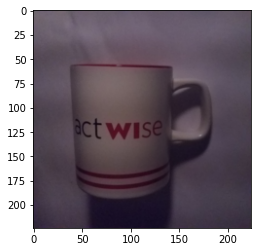

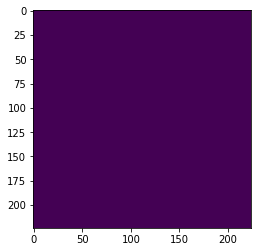

(224, 224)


In [636]:
def get_object_mask(input_image):
    #print(test[-3][:])
    test = inv_normalize(input_image)
    test = np.uint8(test.numpy()*255).transpose((1,2,0))
    test = 1 - test
    #test = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(test, cv2.COLOR_RGB2GRAY)
    th, thgray = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY); 
    #blurred = cv2.GaussianBlur(thgray, (9, 9), 0)
    th, blurred = cv2.threshold(thgray, 0, 255, cv2.THRESH_BINARY_INV)
    edged = cv2.Canny(blurred, 1, 250, L2gradient=True)   
    #imgplot = plt.imshow(blurred, cmap="gray")
    #plt.show()
    return thgray
    #imshow(input_image[0])
    #applying closing function
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7))
    closed = cv2.morphologyEx(blurred, cv2.MORPH_CLOSE, kernel)    #finding_contours
    (cnts, _) = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)   
    #cnts = [] #only for plate class 
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        cv2.drawContours(closed, [approx], -1, (0, 255, 0), 2)    
    th, im_th = cv2.threshold(closed, 254, 255, cv2.THRESH_BINARY_INV);    
    h, w = im_th.shape[:2]
    im_floodfill = im_th.copy()
    mask = np.zeros((h+2, w+2), np.uint8)
    cv2.floodFill(im_floodfill, mask, (0,0), 0);    # Invert floodfilled image
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)    # Combine the two images to get the foreground.
    #imshow(im_th)
    #plt.show()
    #imshow(im_floodfill_inv)
    #plt.show()
    im_out = im_th ^ im_floodfill_inv
    im_out = cv2.GaussianBlur(im_out, (3, 3), 0)
    return im_out
print(type(img_input))
imshow_tensor(img_input.cpu(),inv_normalize)
imgplot = plt.imshow(get_object_mask(img_input.cpu()))
plt.show()
print(get_object_mask(img_input.cpu()).shape)

In [637]:
def imcorr(repla):
    newrep = torch.zeros_like(repla, dtype=torch.float)
    rp = torch.tensor([-1.25006,  2.40351, -0.15585,  0.00132])
    gp = torch.tensor([-1.09171,  2.20569, -0.11374, -0.00064])
    bp = torch.tensor([-1.04359,  1.84006,  0.21149, -0.00933])
    newrep[0] = rp[0] * torch.pow(repla[0], 3) + rp[1] * torch.pow(repla[0], 2) + rp[2] * repla[0] + rp[3]
    newrep[1] = gp[0] * torch.pow(repla[1], 3) + gp[1] * torch.pow(repla[1], 2) + gp[2] * repla[1] + gp[3]
    newrep[2] = bp[0] * torch.pow(repla[2], 3) + bp[1] * torch.pow(repla[2], 2) + bp[2] * repla[2] + bp[3]
    return newrep

img_dir = "./images/original/mug/"
image_list = [Image.open(img_dir+x) for x in os.listdir(img_dir)]
train_image_size = 252
image_tensors = torch.cat([
                pil_to_tensor(
                    x.resize((train_image_size,train_image_size)))
                     .unsqueeze(0) for x in image_list])
image_tensors = image_tensors.to(device)

In [638]:
def get_polynomial(margin):
    x = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    out = []
    for i in range(3):
        y = [max(0, xi + random.random()*2*margin - margin) for xi in x]
        out.append(np.polyfit(x,y,3))
    return out
def imcorr2(repla, coeff):
    newrep = torch.zeros_like(repla, dtype=torch.float)
    rp = coeff[0]
    gp = coeff[1]
    bp = coeff[2]
    newrep[0] = rp[0] * torch.pow(repla[0], 3) + rp[1] * torch.pow(repla[0], 2) + rp[2] * repla[0] + rp[3]
    newrep[1] = gp[0] * torch.pow(repla[1], 3) + gp[1] * torch.pow(repla[1], 2) + gp[2] * repla[1] + gp[3]
    newrep[2] = bp[0] * torch.pow(repla[2], 3) + bp[1] * torch.pow(repla[2], 2) + bp[2] * repla[2] + bp[3]
    return newrep

[ 1.08029677 -0.94089861  0.92560677  0.08857083]


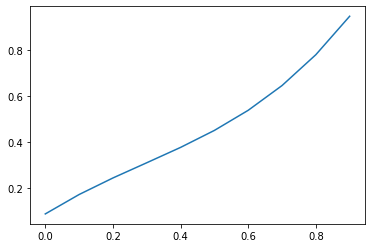

In [639]:
x = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
y = [max(0, xi + random.random()*2*0.2 - 0.2) for xi in x]
coeffs = np.polyfit(x,y,3)[::-1]
print(coeffs[::-1])
y = np.array([np.sum(np.array([coeffs[i]*(j**i) for i in range(len(coeffs))])) for j in x])
plt.plot(x, y)
plt.show()

In [640]:
def get_image_batch(batch_size, train_image_size):
    selected_images = indices = torch.randperm(len(image_list))[:batch_size]
    return image_tensors[selected_images]

In [641]:
account_resize = True

In [642]:
img_full = Image.open('images/original/col_full.jpg')

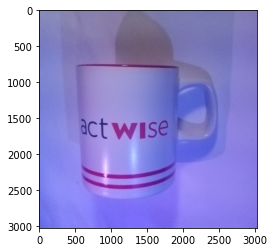

In [643]:
imshow(img_full)

In [644]:
#For resize post convolution
if account_resize:
    repeat_size = int(3024/3024)
    img = img.resize((252,252))
    model_img_size = img.size[0]
    img_t = pil_to_tensor(img)
    img_t = img_t.to(device)
    img_f = pil_to_tensor(img_full.resize((252,252))).to(device)
    def resize2d(img, size):
        return (F.adaptive_avg_pool2d(Variable(img), size)).data
    def upsample2d(img, size=224):
        upsample = nn.Upsample(size=size, mode='bilinear', align_corners=False)
        return upsample(torch.unsqueeze(img, 0))[0]
else:
    model_img_size = 224

In [645]:
# typical exposure is in form 1/n s. Available: 15, 20, 25 30, 40, 50, 60, 80, 100, 125, 160, 200, 250
exposure = 2000 
exp_micros = 1000000/exposure          # get exposure in microseconds
img_ratio = 3024 / model_img_size      # every row in model is img_ratio rows in original image
model_tr = 10 * img_ratio              # multiply real tr (10 micros) by img_ratio to find model tr
conv_size = exp_micros / model_tr      # divide exposure time by tr to find convolution size
conv_size = int(conv_size)             # Need closest integer approximation. Won't cause a significant difference
conv_size

4

In [672]:
sz = model_img_size + conv_size - 1 # 300   #Length of input signal
c = 0    #Ambient light ratio
c_limits = [0,0]
batch = 32
channels = 3
# change of variable term to optimise on
w = torch.rand([channels,sz,1], requires_grad=True, dtype=torch.float, device=device)

#Create the mask to only illuminate the object
mask = torch.tensor(get_object_mask(img_input.cpu()), dtype=torch.float, device=device)
mask = mask / torch.max(mask)


#Target and original class labels
orig = torch.tensor([classidx], dtype=torch.long, device=device)

#Model parameters
lr = 1e-1
n_epochs = 5
#optimizer = optim.SGD([w], lr=lr, momentum=0.9, nesterov=True)
optimizer = optim.Adam([w], lr=0.01)
loss_fn = nn.CrossEntropyLoss()

In [673]:
n_epochs = 10000
classes_to_skip = [classidx]#, 901, 968, 647,899]#,725,441,505,441,969,438,967]
targidx = 722
target = torch.tensor([targidx], dtype=torch.long, device=device)

  0%|          | 0/10000 [00:00<?, ?it/s]

tensor(8.2899, device='cuda:0', grad_fn=<NllLossBackward>) tensor(0.5154, device='cuda:0', grad_fn=<NllLossBackward>)


 10%|█         | 1000/10000 [03:44<32:57,  4.55it/s]

tensor(5.1790, device='cuda:0', grad_fn=<NllLossBackward>) tensor(1.7138, device='cuda:0', grad_fn=<NllLossBackward>)


 20%|██        | 2000/10000 [07:31<29:17,  4.55it/s]

tensor(3.3655, device='cuda:0', grad_fn=<NllLossBackward>) tensor(3.0442, device='cuda:0', grad_fn=<NllLossBackward>)


 30%|███       | 3000/10000 [11:16<25:35,  4.56it/s]

tensor(2.2939, device='cuda:0', grad_fn=<NllLossBackward>) tensor(4.3648, device='cuda:0', grad_fn=<NllLossBackward>)


 40%|████      | 4000/10000 [15:02<21:57,  4.56it/s]

tensor(1.7280, device='cuda:0', grad_fn=<NllLossBackward>) tensor(4.0907, device='cuda:0', grad_fn=<NllLossBackward>)


 50%|█████     | 5000/10000 [18:48<18:17,  4.56it/s]

tensor(1.7489, device='cuda:0', grad_fn=<NllLossBackward>) tensor(4.0051, device='cuda:0', grad_fn=<NllLossBackward>)


 60%|██████    | 6000/10000 [22:34<14:37,  4.56it/s]

tensor(0.9414, device='cuda:0', grad_fn=<NllLossBackward>) tensor(4.2595, device='cuda:0', grad_fn=<NllLossBackward>)


 70%|███████   | 7000/10000 [26:20<10:58,  4.56it/s]

tensor(1.6466, device='cuda:0', grad_fn=<NllLossBackward>) tensor(4.3250, device='cuda:0', grad_fn=<NllLossBackward>)


 80%|████████  | 8000/10000 [30:06<07:19,  4.55it/s]

tensor(1.2270, device='cuda:0', grad_fn=<NllLossBackward>) tensor(4.6655, device='cuda:0', grad_fn=<NllLossBackward>)


 90%|█████████ | 9000/10000 [33:52<03:40,  4.54it/s]

tensor(0.8836, device='cuda:0', grad_fn=<NllLossBackward>) tensor(4.5125, device='cuda:0', grad_fn=<NllLossBackward>)


100%|██████████| 10000/10000 [37:39<00:00,  4.43it/s]


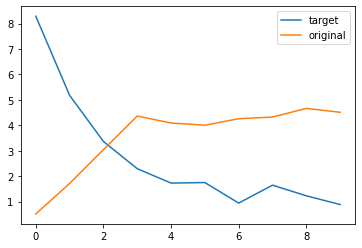

In [674]:
#Track the loss to target and original class
targloss = []
origloss = []

#obj_dict = {}

#Optimisation loop. initially untargeted
for epoch in tqdm(range(n_epochs)):
    
    #Switch to targeted at halfway point
    half = False#epoch < n_epochs//6
    if epoch == 12*n_epochs//6:
        tops = out.topk(40).indices[0]
        for t in tops:
            #print(t.item())
            if t.item() not in classes_to_skip: 
                targidx = t.item()
        targidx = 722
        #targidx = tops[0].item() if tops[0].item() != classidx else tops[1].item()
        target = torch.tensor([targidx], dtype=torch.long, device=device)
        print("Switching from untarget to target {}".format(targidx))
    
    if channels==1:
        n_w = w.repeat(3,1,1)
    else:
        n_w = w
    
    # For resize post convolution
    if account_resize:
        n_w = torch.repeat_interleave(n_w, repeats=repeat_size, dim=1)
    
    sig_height = model_img_size + conv_size - 1
    gy, new_w, sh = fttogy(n_w, batch, None, c_limits, sig_height, conv_size, device, 0, shifting=True)
    #display(tensor_to_pil(gy[0]))
    #color correction
    #gy = torch.cat([imcorr(i).unsqueeze(0) for i in gy])
    
    #gamma correction
    #gy = torch.pow(gy, 1/2.2)
    
    if account_resize:
        #For resize post convolution
        #inp = gy*img_t
        #gy *= random.random()*0.7 + 0.7
        
        #Add noise to input signal
        #xx = 0.4*torch.rand((gy.size()[0],gy.size()[1]),device=device)-0.2
        #xx = xx.unsqueeze(2).unsqueeze(3).repeat(1,1,252,1)
        #gy += xx
        #gy = torch.clamp(gy, min=0, max=1)
        
        inp = torch.pow(0.0000001 + torch.pow(img_t,2.2) + gy*(torch.pow(img_f,2.2)-torch.pow(img_t,2.2)), 1/2.2)
        
        #For multiple train images
        #inp = gy*get_image_batch(batch, 252)
    else: 
        inp = gy*inv_normalize(img_input)
    
    #Gaussian Noise
    #inp = inp + torch.randn(inp.size(),device=device)*0.005
    #inp = torch.clamp(inp,min=0,max=1)
    
    #Uniform noise to each row
    #inp = inp*(1 + torch.rand(inp.size()[:-1],device=device).unsqueeze(-1)*0.4 - 0.2)
    #inp = torch.clamp(inp,min=0,max=1)
    
    #affine transforming the image
    inp = inp*(0.7+torch.rand(inp.size()[:-2],device=device).unsqueeze(-1).unsqueeze(-1)*0.6) + (-0.2+torch.rand(inp.size()[:-2],device=device).unsqueeze(-1).unsqueeze(-1)*0.4)
    
    #apply random color correction
    #inp = torch.cat([imcorr2(i, get_polynomial(0.2)).unsqueeze(0) for i in inp])
    
    if account_resize:
        #For resize post convolution
        inp = torch.cat([forward_normalize(upsample2d(i,224)).unsqueeze(0) for i in inp])
    else: 
        inp = torch.cat([forward_normalize(i).unsqueeze(0) for i in inp])
    inp = inp.to(device)
    out = pretrained_model(inp)

    #Calculate Loss depended on if targeted or untargeted
    if not half: targLoss = loss_fn(out, target.repeat(batch))
    origLoss = loss_fn(out, orig.repeat(batch))
    loss = -origLoss if half else targLoss
    if epoch%1000 == 0:
        targloss.append(0 if half else targLoss)
        origloss.append(origLoss)
        if not half: print(targLoss, origLoss) 
        else: print(origLoss)
    loss.backward()   
    
    if epoch%10==0:   # batch 32 === update after 10 for ~224
        optimizer.step()
        optimizer.zero_grad()
        del loss
        torch.cuda.empty_cache()
    
    if epoch!=n_epochs-1:
        del inp
        del new_w
    #else:
        #saving w to be used for prediction
        #torch.save(n_w,'w_0.5_764.pt')

    #Code to check gpu allocation    
    '''
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
                #print(type(obj), obj.size())
                if type(obj) not in obj_dict:
                    obj_dict[type(obj)] = 1
                else:
                    obj_dict[type(obj)] += 1
        except: pass
    print(obj_dict)
    obj_dict.clear()
    '''
    
#View original loss and target loss
plt.plot(targloss, label="target")
plt.plot(origloss, label="original")
plt.legend()
plt.show()

In [675]:
#Create softmax layer to view probabilities
lay2 = torch.nn.Softmax(dim=1)
#targidx = 4
prob = lay2(out)
maxcls = prob.max(1)
#print(maxcls)
for i in range(batch):
    #print("alpha: {}".format(c[i].item()))
    print("target {}: {}%".format(targidx,prob[i][targidx]))
    print("Orig {}: {}%".format(classidx,prob[i][classidx]))
    print("Class is {} ({}) with confidence {}%\n".format(maxcls.indices[i].item(),class_dict[maxcls.indices[i].item()],maxcls.values[i].item()*100))

target 722: 0.10734354704618454%
Orig 504: 0.025574134662747383%
Class is 720 (pill bottle) with confidence 32.28330612182617%

target 722: 0.2568557858467102%
Orig 504: 0.03237423673272133%
Class is 712 (Petri dish) with confidence 30.66878318786621%

target 722: 0.7275243997573853%
Orig 504: 0.04148593172430992%
Class is 722 (ping-pong ball) with confidence 72.75243997573853%

target 722: 0.9484710693359375%
Orig 504: 0.003033143701031804%
Class is 722 (ping-pong ball) with confidence 94.84710693359375%

target 722: 0.5108808875083923%
Orig 504: 0.007978852838277817%
Class is 722 (ping-pong ball) with confidence 51.08808875083923%

target 722: 0.9242613315582275%
Orig 504: 0.021462049335241318%
Class is 722 (ping-pong ball) with confidence 92.42613315582275%

target 722: 0.48114013671875%
Orig 504: 0.0032328690867871046%
Class is 722 (ping-pong ball) with confidence 48.114013671875%

target 722: 0.7552562952041626%
Orig 504: 0.026399752125144005%
Class is 722 (ping-pong ball) with co

In [676]:
classidx = 504
print('source :'+str(np.array([float(prob[i][classidx]) for i in range(batch) if prob.max(1).indices[i] == classidx]).mean()))
print('target :'+str(np.array([float(prob[i][722]) for i in range(batch)]).mean()))
print('max :'+str(np.array([float(prob[i][prob.max(1).indices[i].item()]) for i in range(batch)]).mean()))

source :0.48498207330703735
target :0.5201979095145361
max :0.5691760275512934


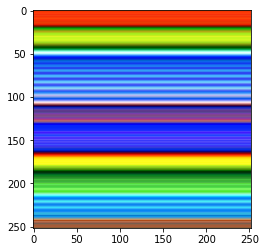

In [679]:
#torch.save(new_w,'saved_inputs/imagenet_iso800_504_targeted722_rgb_resize252_autofix_affine_0.3_0.2.pt')
test = torch.ones([3,252,252])
imshow_tensor(forward_normalize(gy[24].detach().cpu()*test), inv_normalize)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


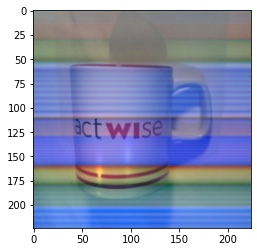

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


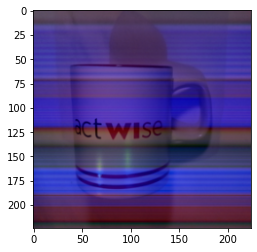

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


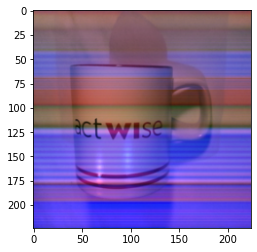

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


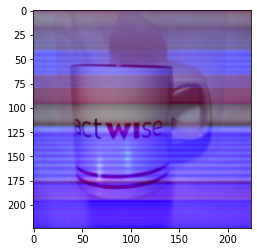

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


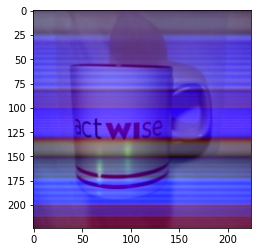

In [678]:
#View input image and adversarial image. Save both
#imshow_tensor(forward_normalize(inv_normalize(img_input.cpu())*c), inv_normalize)
imshow_tensor(inp[5].detach().cpu(),inv_normalize)
imshow_tensor(inp[10].detach().cpu(),inv_normalize)
imshow_tensor(inp[15].detach().cpu(),inv_normalize)
imshow_tensor(inp[20].detach().cpu(),inv_normalize)
imshow_tensor(inp[25].detach().cpu(),inv_normalize)
#saveim(img_input.cpu(), "original_{}.png".format(classidx),inv_normalize)
#saveim(forward_normalize(inv_normalize(img_input.cpu())*c), "original_c{}_{}.png".format(c,classidx),inv_normalize)
#saveim(inp, "src{}_c{}_sz{}_tg{}.png".format(classidx,c,sz,targidx),inv_normalize)

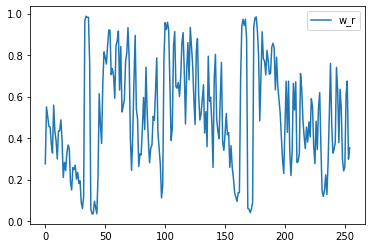

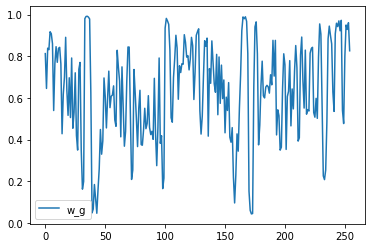

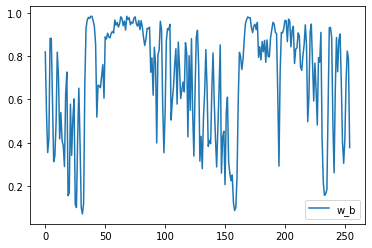

In [603]:
plt.plot(torch.flatten(new_w[0][0]).detach().cpu(), label="w_r")
plt.legend()
plt.show()
plt.plot(torch.flatten(new_w[0][1]).detach().cpu(), label="w_g")
plt.legend()
plt.show()
plt.plot(torch.flatten(new_w[0][2]).detach().cpu(), label="w_b")
plt.legend()
plt.show()

In [ ]:
#View the attack signal colour channels separately
test = torch.ones([3,224,224], device=device)
re = test * split(gy_mask,0)
gr = test * split(gy_mask,1)
bl = test * split(gy_mask,2)
imshow_tensor(forward_normalize(re.detach().cpu()), inv_normalize)
imshow_tensor(forward_normalize(gr.detach().cpu()), inv_normalize)
imshow_tensor(forward_normalize(bl.detach().cpu()), inv_normalize)

In [ ]:
imstats("original_919.png")
imstats("original_c0.5_919.png")
imstats("original_c0.3_919.png")

In [ ]:
#Get classes
CLASS_URL = 'https://gist.githubusercontent.com/yrevar/6135f1bd8dcf2e0cc683/raw/d133d61a09d7e5a3b36b8c111a8dd5c4b5d560ee/imagenet1000_clsid_to_human.pkl'
class_dict = pickle.load(urllib.request.urlopen(CLASS_URL))

#Retrieve image and assign class
IMG_URL = "https://bloximages.chicago2.vip.townnews.com/chippewa.com/content/tncms/assets/v3/editorial/c/ca/cca0d87d-8d7c-520f-b012-bc065d18b3dd/553cbf5aa0ffb.image.jpg?crop=200%2C200%2C0%2C8&resize=1200%2C1200&order=crop%2Cresize"
classidx = 919
response = requests.get(IMG_URL)
img = Image.open(io.BytesIO(response.content))
print(img.size)
imshow(img)

In [ ]:
test_length = 5
test = torch.tensor([[0., 1., 1., 1., 1.],
        [2., 2., 2., 2., 2.],
        [3., 3., 3., 3., 3.]],device=device)
print(test)
test_batch = 2
test_shifted = shift_operation(test.unsqueeze(0).repeat(test_batch,1,1,1).view(-1, test_length, 1), [0,1]).view(test_batch,3,test_length,1)
print(test_shifted.shape)
print(test_shifted)
test_reshaped = test_shifted.view([3,1,test_length,test_batch])
treshape = test_shifted.transpose(0,3).transpose(0,1)
print(test_reshaped.shape)
print(test_reshaped)
print(treshape)

In [ ]:
a = torch.rand((8,8),dtype=torch.float)
import math
pi = math.pi
print(a)
print(torch.round(a*45)/45)
print(torch.mean(torch.abs(a - torch.round(a*45)/45)))
b = a-torch.sin(90*pi*a)/(90*pi)
print(b)
print(torch.mean(torch.abs(b - torch.round(a*45)/45)))
c = b-torch.sin(90*pi*b)/(90*pi)
print(c)
print(torch.mean(torch.abs(c - torch.round(a*45)/45)))
d = c-torch.sin(90*pi*c)/(90*pi)
print(d)
print(torch.mean(torch.abs(d - torch.round(a*45)/45)))